In [1]:
import jax.numpy as jnp
from jax import random,vmap
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import NUTS,MCMC,HMC,init_to_feasible,init_to_value
from numpyro.infer.util import find_valid_initial_params
import numpyro.distributions as dist
import numpy as np
np.random.seed(16)
import arviz as az
import json
import datetime
from matplotlib import rc
import os
from matplotlib.ticker import FormatStrFormatter
import tqdm

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

## Step 0. Draw events & simulate data

In [2]:
# Number of events to "observe"
n_obs = 120

# True underlying population (mixture between Gaussians)
mu_low_true = 0
sig_low_true = 0.75
mu_high_true = 1.5
sig_high_true = 0.1
frac_high = 0.65

# Draw true values
xs_true = np.zeros(n_obs)
for i in range(n_obs):
    if np.random.random()<frac_high:
        xs_true[i] = np.random.normal(loc=mu_high_true,scale=sig_high_true)
    else:
        xs_true[i] = np.random.normal(loc=mu_low_true,scale=sig_low_true)


# Draw "observed" maximum likelihood values
sig_obs = 10.**np.random.normal(size=n_obs,loc=-0.2,scale=0.2)
xs_ml = np.random.normal(loc=xs_true,scale=sig_obs)

# Draw mock posterior samples about max likelihood values
mock_samples = np.transpose([np.random.normal(size=500,loc=x,scale=s) for x,s in zip(xs_ml,sig_obs)])

## Step 1. Animation frames illustrating errorless measurement.

Build the first frame --

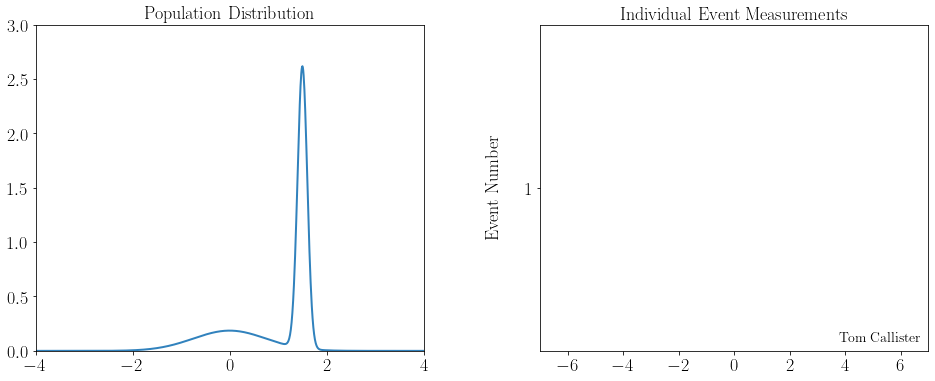

In [3]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
x_grid = np.linspace(-4,4,1000)
y_truth = (1.-frac_high)*jnp.exp(-(x_grid-mu_low_true)**2/(2.*sig_low_true**2))/jnp.sqrt(2.*np.pi*sig_low_true**2)\
                + frac_high*jnp.exp(-(x_grid-mu_high_true)**2/(2.*sig_high_true**2))/jnp.sqrt(2.*np.pi*sig_high_true**2)

ax.plot(x_grid,y_truth,color='#3182bd',lw=2)

ax.tick_params(labelsize=18)
ax.set_xlim(-4,4)
ax.set_ylim(0,3.)
ax.set_title('Population Distribution',fontsize=18)
ax.set_rasterization_zorder(2)

ax = fig.add_subplot(122)
ax.set_ylim(0.75,1.25)
ax.set_yticks([1])
ax.set_xlim(-7,7)
ax.tick_params(labelsize=18)
ax.set_title('Individual Event Measurements',fontsize=18)
ax.set_ylabel('Event Number',fontsize=18)
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.text(0.98,0.03,"Tom Callister",horizontalalignment='right',fontsize=14,transform=ax.transAxes)

fig.subplots_adjust(wspace=0.3)

plt.savefig('step_01_errorless_measurement/errorless_frame_000.jpg',dpi=150)
plt.show()

And build subsequent frames --

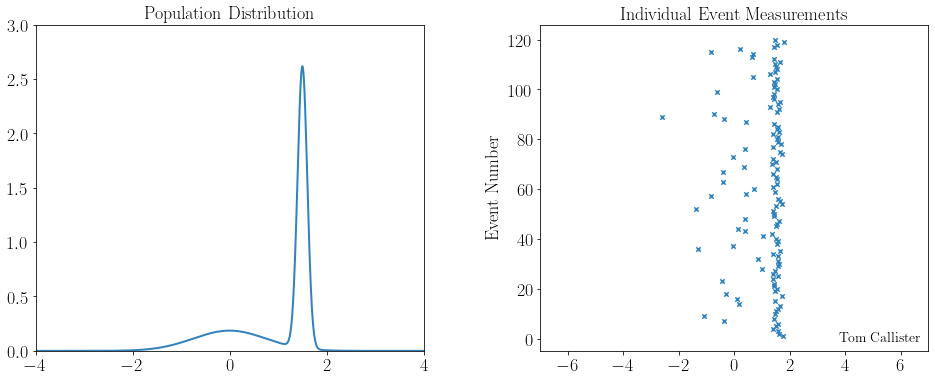

In [4]:
fig = plt.figure(figsize=(16,6))

for nEvents in range(1,n_obs+1):

    ax = fig.add_subplot(121)
    x_grid = np.linspace(-4,4,1000)
    y_truth = (1.-frac_high)*jnp.exp(-(x_grid-mu_low_true)**2/(2.*sig_low_true**2))/jnp.sqrt(2.*np.pi*sig_low_true**2)\
                    + frac_high*jnp.exp(-(x_grid-mu_high_true)**2/(2.*sig_high_true**2))/jnp.sqrt(2.*np.pi*sig_high_true**2)

    ax.plot(x_grid,y_truth,color='#3182bd',lw=2)

    ax.tick_params(labelsize=18)
    ax.set_xlim(-4,4)
    ax.set_ylim(0,3.)
    ax.set_title('Population Distribution',fontsize=18)
    ax.set_rasterization_zorder(2)

    ax = fig.add_subplot(122)
    
    if nEvents==1:
        ax.set_ylim(0.75,1.25)
        ax.set_yticks([1])
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='x',s=180,color='#3182bd',zorder=0)
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='.',s=200,color='#3182bd',zorder=0)
    elif nEvents==2:
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='x',s=180,color='#3182bd',zorder=0)
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='.',s=200,color='#3182bd',zorder=0)
        ax.set_ylim(0.25,2.75)
        ax.set_yticks([1,2])
    else:
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='x',s=180.*(nEvents/3.)**(-0.6),color='#3182bd',zorder=0)
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='.',s=200.*(nEvents/3.)**(-0.6),color='#3182bd',zorder=0)
        if nEvents<=5:
            ax.set_yticks(np.arange(1,nEvents+1))
        
    ax.set_xlim(-7,7)
    ax.tick_params(labelsize=18)
    ax.set_title('Individual Event Measurements',fontsize=18)
    ax.set_ylabel('Event Number',fontsize=18)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_rasterization_zorder(2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.text(0.98,0.03,"Tom Callister",horizontalalignment='right',fontsize=14,transform=ax.transAxes)

    fig.subplots_adjust(wspace=0.3)
    plt.savefig('step_01_errorless_measurement/errorless_frame_{0:03d}.jpg'.format(nEvents),dpi=150)
    
    if nEvents!=n_obs:
        plt.clf()
    else:
        plt.show()

## Step 2. Population reconstruction from perfect measurements

Set up the problem --

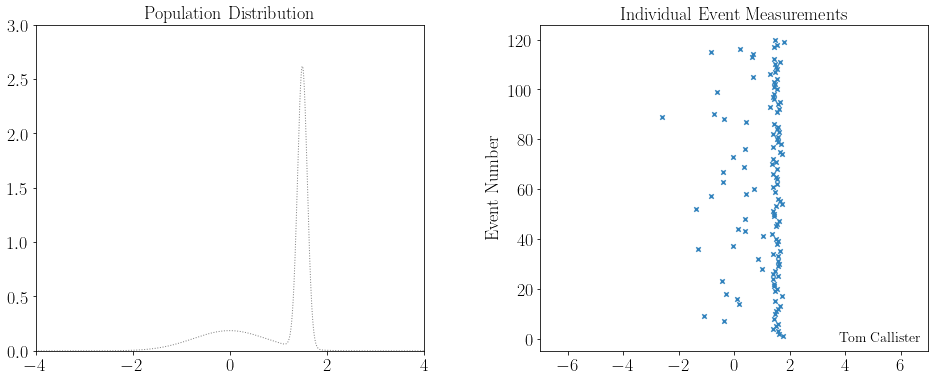

In [5]:
nEvents = 120
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
x_grid = np.linspace(-4,4,1000)
y_truth = (1.-frac_high)*jnp.exp(-(x_grid-mu_low_true)**2/(2.*sig_low_true**2))/jnp.sqrt(2.*np.pi*sig_low_true**2)\
                + frac_high*jnp.exp(-(x_grid-mu_high_true)**2/(2.*sig_high_true**2))/jnp.sqrt(2.*np.pi*sig_high_true**2)

ax.plot(x_grid,y_truth,color='grey',lw=1,ls=':')

ax.tick_params(labelsize=18)
ax.set_xlim(-4,4)
ax.set_ylim(0,3.)
ax.set_title('Population Distribution',fontsize=18)
ax.set_rasterization_zorder(2)

ax = fig.add_subplot(122)

ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='x',s=180.*(nEvents/3.)**(-0.6),color='#3182bd',zorder=0)
ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='.',s=200.*(nEvents/3.)**(-0.6),color='#3182bd',zorder=0)

ax.set_xlim(-7,7)
ax.tick_params(labelsize=18)
ax.set_title('Individual Event Measurements',fontsize=18)
ax.set_ylabel('Event Number',fontsize=18)
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.set_rasterization_zorder(2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.text(0.98,0.03,"Tom Callister",horizontalalignment='right',fontsize=14,transform=ax.transAxes)

fig.subplots_adjust(wspace=0.3)
plt.savefig('step_02_errorless_reconstruction_setup.jpg'.format(nEvents),dpi=150)
plt.show()

Now make frames for reconstruction gif --

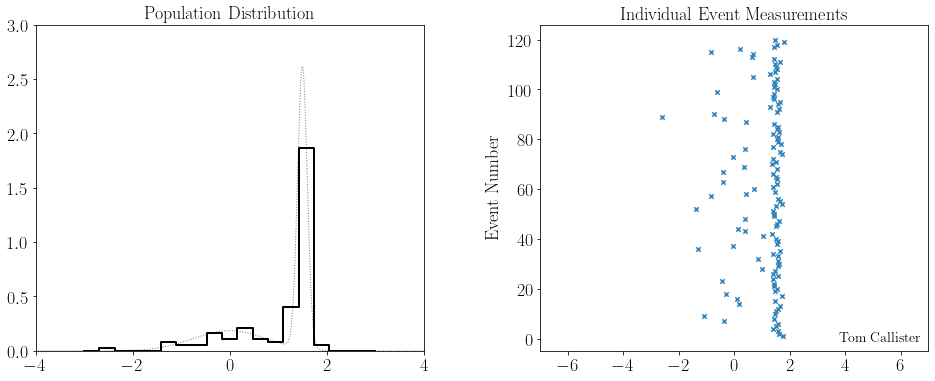

In [6]:
fig = plt.figure(figsize=(16,6))

for nEvents in range(1,n_obs+1):

    ax = fig.add_subplot(121)
    x_grid = np.linspace(-4,4,1000)
    y_truth = (1.-frac_high)*jnp.exp(-(x_grid-mu_low_true)**2/(2.*sig_low_true**2))/jnp.sqrt(2.*np.pi*sig_low_true**2)\
                    + frac_high*jnp.exp(-(x_grid-mu_high_true)**2/(2.*sig_high_true**2))/jnp.sqrt(2.*np.pi*sig_high_true**2)

    ax.plot(x_grid,y_truth,color='grey',lw=1,ls=':')
    
    counts,bins = np.histogram(xs_true[:nEvents],bins=np.linspace(-3,3,20))
    dx = bins[1]-bins[0]
    ax.step(bins,np.append(counts,0.)/119/dx,where='post',color='black',lw=2)

    ax.tick_params(labelsize=18)
    ax.set_xlim(-4,4)
    ax.set_ylim(0,3.)
    ax.set_title('Population Distribution',fontsize=18)
    ax.set_rasterization_zorder(2)

    ax = fig.add_subplot(122)

    if nEvents==1:
        ax.set_ylim(0.75,1.25)
        ax.set_yticks([1])
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='x',s=180,color='#3182bd',zorder=0)
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='.',s=200,color='#3182bd',zorder=0)
    elif nEvents==2:
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='x',s=180,color='#3182bd',zorder=0)
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='.',s=200,color='#3182bd',zorder=0)
        ax.set_ylim(0.25,2.75)
        ax.set_yticks([1,2])
    else:
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='x',s=180.*(nEvents/3.)**(-0.6),color='#3182bd',zorder=0)
        ax.scatter(xs_true[:nEvents],np.arange(1,nEvents+1),marker='.',s=200.*(nEvents/3.)**(-0.6),color='#3182bd',zorder=0)
        if nEvents<=5:
            ax.set_yticks(np.arange(1,nEvents+1))
            
    ax.set_xlim(-7,7)
    ax.tick_params(labelsize=18)
    ax.set_title('Individual Event Measurements',fontsize=18)
    ax.set_ylabel('Event Number',fontsize=18)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_rasterization_zorder(2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.text(0.98,0.03,"Tom Callister",horizontalalignment='right',fontsize=14,transform=ax.transAxes)

    fig.subplots_adjust(wspace=0.3)
    plt.savefig('step_02_errorless_reconstruction/histogram_{0:03d}.jpg'.format(nEvents),dpi=150)
    
    if nEvents!=n_obs:
        plt.clf()
    else:
        plt.show()

## Step 3. Uncertain measurements

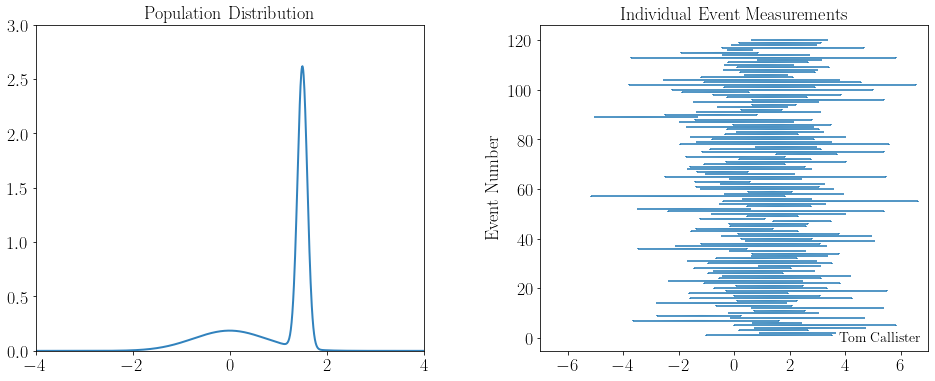

In [7]:
fig = plt.figure(figsize=(16,6))

for nEvents in range(1,n_obs+1):

    ax = fig.add_subplot(121)
    x_grid = np.linspace(-4,4,1000)
    y_truth = (1.-frac_high)*jnp.exp(-(x_grid-mu_low_true)**2/(2.*sig_low_true**2))/jnp.sqrt(2.*np.pi*sig_low_true**2)\
                    + frac_high*jnp.exp(-(x_grid-mu_high_true)**2/(2.*sig_high_true**2))/jnp.sqrt(2.*np.pi*sig_high_true**2)

    ax.plot(x_grid,y_truth,color='#3182bd',lw=2)

    ax.tick_params(labelsize=18)
    ax.set_xlim(-4,4)
    ax.set_ylim(0,3.)
    ax.set_title('Population Distribution',fontsize=18)
    ax.set_rasterization_zorder(2)

    ax = fig.add_subplot(122)
            
    if nEvents==1:
        ax.set_ylim(0.75,1.25)
        ax.set_yticks([1])
        ax.violinplot(mock_samples[:,:nEvents],vert=False,widths=0.06)
    elif nEvents==2:
        ax.violinplot(mock_samples[:,:nEvents],vert=False,widths=0.3)
        ax.set_ylim(0.25,2.75)
        ax.set_yticks([1,2])
    else:
        ax.violinplot(mock_samples[:,:nEvents],vert=False)
        if nEvents<=5:
            ax.set_yticks(np.arange(1,nEvents+1))
        
    ax.set_xlim(-7,7)
    ax.tick_params(labelsize=18)
    ax.set_title('Individual Event Measurements',fontsize=18)
    ax.set_ylabel('Event Number',fontsize=18)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_rasterization_zorder(2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.text(0.98,0.03,"Tom Callister",horizontalalignment='right',fontsize=14,transform=ax.transAxes)

    fig.subplots_adjust(wspace=0.3)
    plt.savefig('step_03_uncertain_measurement/violin_frame_{0:03d}.jpg'.format(nEvents),dpi=150)
    
    if nEvents!=n_obs:
        plt.clf()
    else:
        plt.show()

## Step 4. Naive population reconstruction with uncertain measurements

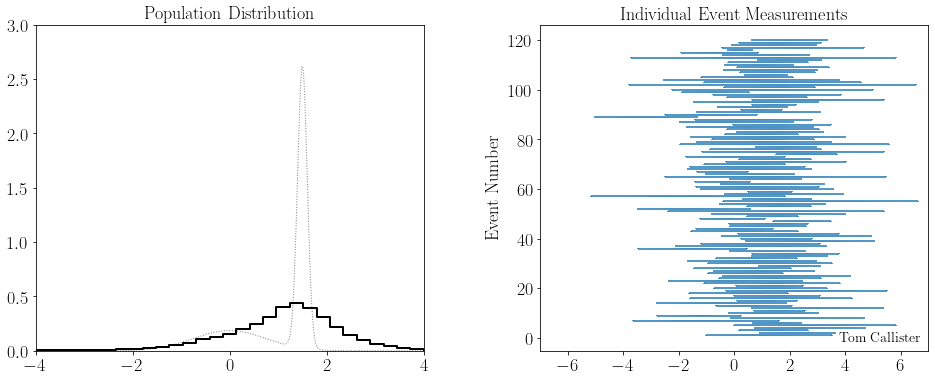

In [8]:
fig = plt.figure(figsize=(16,6))

for nEvents in range(1,n_obs+1):

    ax = fig.add_subplot(121)
    x_grid = np.linspace(-4,4,1000)
    y_truth = (1.-frac_high)*jnp.exp(-(x_grid-mu_low_true)**2/(2.*sig_low_true**2))/jnp.sqrt(2.*np.pi*sig_low_true**2)\
                    + frac_high*jnp.exp(-(x_grid-mu_high_true)**2/(2.*sig_high_true**2))/jnp.sqrt(2.*np.pi*sig_high_true**2)

    ax.plot(x_grid,y_truth,color='grey',lw=1,ls=':')
    
    counts,bins = np.histogram(mock_samples[:,:nEvents],bins=np.linspace(-4,4,30))
    dx = bins[1]-bins[0]
    ax.step(bins,np.append(counts,0.)/(119*500)/dx,where='post',color='black',lw=2)
    
    ax.tick_params(labelsize=18)
    ax.set_xlim(-4,4)
    ax.set_ylim(0,3.)
    ax.set_title('Population Distribution',fontsize=18)
    ax.set_rasterization_zorder(2)

    ax = fig.add_subplot(122)

    if nEvents==1:
        ax.set_ylim(0.75,1.25)
        ax.set_yticks([1])
        ax.violinplot(mock_samples[:,:nEvents],vert=False,widths=0.06)
    elif nEvents==2:
        ax.violinplot(mock_samples[:,:nEvents],vert=False,widths=0.3)
        ax.set_ylim(0.25,2.75)
        ax.set_yticks([1,2])
    else:
        ax.violinplot(mock_samples[:,:nEvents],vert=False)
        if nEvents<=5:
            ax.set_yticks(np.arange(1,nEvents+1))
    
    ax.set_xlim(-7,7)
    ax.tick_params(labelsize=18)
    ax.set_title('Individual Event Measurements',fontsize=18)
    ax.set_ylabel('Event Number',fontsize=18)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_rasterization_zorder(2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.text(0.98,0.03,"Tom Callister",horizontalalignment='right',fontsize=14,transform=ax.transAxes)

    fig.subplots_adjust(wspace=0.3)
    plt.savefig('step_04_naive_uncertain_reconstruction/histogram_{0:03d}.jpg'.format(nEvents),dpi=150)
    
    if nEvents!=n_obs:
        plt.clf()
    else:
        plt.show()

## Step 5. Proper hierarchical inference

In [9]:
def model(nEvents):
    
    mu_low = numpyro.sample("mu_low",dist.Uniform(-5,5))
    mu_high_frac = numpyro.sample("mu_high_frac",dist.Uniform(0,1))
    mu_high = numpyro.deterministic("mu_high",mu_low + (5.-mu_low)*mu_high_frac)
    sig_low = numpyro.sample("sig_low",dist.Uniform(0.1,3))
    sig_high = numpyro.sample("sig_high",dist.Uniform(0.1,3))
    fhigh = numpyro.sample("fhigh",dist.Uniform(0,1))
    
    def logp(x,s):
        
        p = (1.-fhigh)*jnp.exp(-(x-mu_low)**2/(2.*(s**2+sig_low**2)))/jnp.sqrt(2.*np.pi*(s**2+sig_low**2))\
                    + fhigh*jnp.exp(-(x-mu_high)**2/(2.*(s**2+sig_high**2)))/jnp.sqrt(2.*np.pi*(s**2+sig_high**2))
        return jnp.log(p)
    
    log_ps = vmap(logp)(xs_ml[:nEvents],sig_obs[:nEvents])
    numpyro.factor("logp",jnp.sum(log_ps))

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 119/120 [12:12<00:06,  6.72s/it]

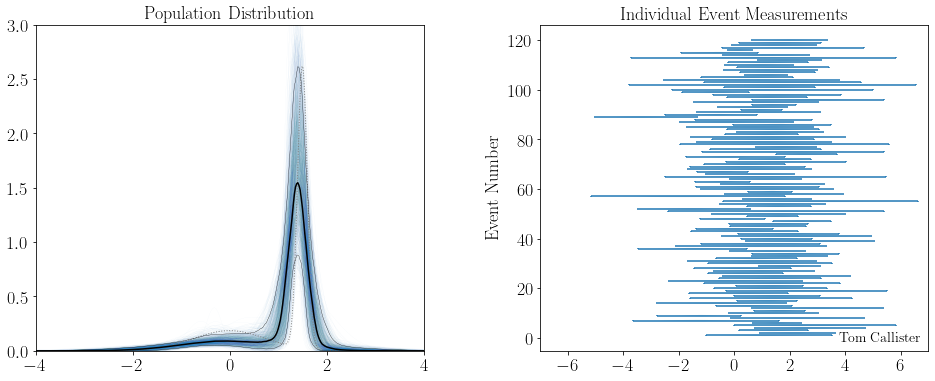

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [12:19<00:00,  6.16s/it]


In [10]:
rng_key = random.PRNGKey(2)

kernel = NUTS(model)
mcmc = MCMC(kernel,num_warmup=1000,num_samples=1000,progress_bar=False)

fig = plt.figure(figsize=(16,6))

for nEvents in tqdm.tqdm(range(1,n_obs+1)):

    rng_key = random.PRNGKey(2)
    mcmc.run(rng_key,nEvents)
    samples = mcmc.get_samples()
    #mcmc.print_summary()

    ax = fig.add_subplot(121)
    x_grid = np.linspace(-4,4,1000)
    y_truth = (1.-frac_high)*jnp.exp(-(x_grid-mu_low_true)**2/(2.*sig_low_true**2))/jnp.sqrt(2.*np.pi*sig_low_true**2)\
                    + frac_high*jnp.exp(-(x_grid-mu_high_true)**2/(2.*sig_high_true**2))/jnp.sqrt(2.*np.pi*sig_high_true**2)

    ax.plot(x_grid,y_truth,color='grey',lw=1,ls=':',zorder=0)
    
    
    p_x_grid = np.zeros((samples['fhigh'].size,x_grid.size))
    for i in range(samples['fhigh'].size):

        mu_low = samples["mu_low"][i]
        mu_high = samples["mu_high"][i]
        sig_low = samples["sig_low"][i]
        sig_high = samples["sig_high"][i]
        fhigh = samples["fhigh"][i]

        ys = (1.-fhigh)*jnp.exp(-(x_grid-mu_low)**2/(2.*sig_low**2))/jnp.sqrt(2.*np.pi*sig_low**2)\
                        + fhigh*jnp.exp(-(x_grid-mu_high)**2/(2.*sig_high**2))/jnp.sqrt(2.*np.pi*sig_high**2)

        p_x_grid[i,:] = ys
        ax.plot(x_grid,ys,color='#3182bd',alpha=0.1,lw=0.1,zorder=-1)

    ax.plot(x_grid[::3],np.median(p_x_grid,axis=0)[::3],color="black",zorder=1)
    ax.plot(x_grid[::3],np.quantile(p_x_grid,0.05,axis=0)[::3],color="black",lw=0.3,zorder=1)
    ax.plot(x_grid[::3],np.quantile(p_x_grid,0.95,axis=0)[::3],color="black",lw=0.3,zorder=1)

    ax.tick_params(labelsize=18)
    ax.set_xlim(-4,4)
    ax.set_ylim(0,3.)
    ax.set_title('Population Distribution',fontsize=18)
    ax.set_rasterization_zorder(2)

    ax = fig.add_subplot(122)
            
    if nEvents==1:
        ax.set_ylim(0.75,1.25)
        ax.set_yticks([1])
        ax.violinplot(mock_samples[:,:nEvents],vert=False,widths=0.06)
    elif nEvents==2:
        ax.violinplot(mock_samples[:,:nEvents],vert=False,widths=0.3)
        ax.set_ylim(0.25,2.75)
        ax.set_yticks([1,2])
    else:
        ax.violinplot(mock_samples[:,:nEvents],vert=False)
        if nEvents<=5:
            ax.set_yticks(np.arange(1,nEvents+1))
        
    ax.set_xlim(-7,7)
    ax.tick_params(labelsize=18)
    ax.set_title('Individual Event Measurements',fontsize=18)
    ax.set_ylabel('Event Number',fontsize=18)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_rasterization_zorder(2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.text(0.98,0.03,"Tom Callister",horizontalalignment='right',fontsize=14,transform=ax.transAxes)

    fig.subplots_adjust(wspace=0.3)
    plt.savefig('step_05_proper_uncertain_reconstruction/frame_{0:03d}.jpg'.format(nEvents),dpi=150)

    if nEvents!=n_obs:
        plt.clf()
    else:
        plt.show()

## Step 6. Proper reconstruction but with a wrong model

In [11]:
def bad_model(xs):
    
    xmin = numpyro.sample("xmin",dist.Uniform(-4,-1))
    xmax = numpyro.sample("xmax",dist.Uniform(1,4)) 
    k1 = numpyro.sample("k1",dist.Normal(6))
    dk = numpyro.sample("dk",dist.Normal(6))
    k2 = numpyro.deterministic("k2",k1+dk)
    x0_unscaled = numpyro.sample("x0_unscaled",dist.Uniform(0,1))
    x0 = numpyro.deterministic("x0",xmin+(xmax-xmin)*x0_unscaled)
    
    c = 6.
    
    x_grid = jnp.linspace(-5,5,300)
    grid_p1 = jnp.power((x_grid+c)/(x0+c),k1)
    grid_p2 = jnp.power((x_grid+c)/(x0+c),k2)
    grid_cutoff_high = jnp.exp(-(x_grid-xmax)**2/0.1**2)
    grid_cutoff_low = jnp.exp(-(x_grid-xmin)**2/0.1**2)
    grid_p = jnp.where(x_grid<=x0,grid_p1,grid_p2)
    grid_p = jnp.where(x_grid>xmin,grid_p,grid_p*grid_cutoff_low)
    grid_p = jnp.where(x_grid<xmax,grid_p,grid_p*grid_cutoff_high)
    norm = jnp.trapz(grid_p,x_grid)
        
    p1 = jnp.power((xs+c)/(x0+c),k1)
    p2 = jnp.power((xs+c)/(x0+c),k2)
    cutoff_high = jnp.exp(-(xs-xmax)**2/0.1**2)
    cutoff_low = jnp.exp(-(xs-xmin)**2/0.1**2)
    
    p = jnp.where(xs<=x0,p1,p2)
    p = jnp.where(xs>xmin,p,p*cutoff_low)
    p = jnp.where(xs<xmax,p,p*cutoff_high)
    
    p = jnp.mean(p/norm,axis=0)
    logp = jnp.sum(jnp.log(p))
        
    numpyro.factor("logp",logp)

In [ ]:
rng_key = random.PRNGKey(3)

kernel = NUTS(bad_model,max_tree_depth=10)
mcmc = MCMC(kernel,num_warmup=500,num_samples=1000,progress_bar=False)

fig = plt.figure(figsize=(16,6))

for nEvents in tqdm.tqdm(range(1,n_obs+1)):

    rng_key = random.PRNGKey(2)
    mcmc.run(rng_key,jnp.array(mock_samples[:,:nEvents]))
    samples = mcmc.get_samples()

    ax = fig.add_subplot(121)
    x_grid = np.linspace(-4,4,1000)
    y_truth = (1.-frac_high)*jnp.exp(-(x_grid-mu_low_true)**2/(2.*sig_low_true**2))/jnp.sqrt(2.*np.pi*sig_low_true**2)\
                    + frac_high*jnp.exp(-(x_grid-mu_high_true)**2/(2.*sig_high_true**2))/jnp.sqrt(2.*np.pi*sig_high_true**2)

    ax.plot(x_grid,y_truth,color='grey',lw=1,ls=':',zorder=0)
    
    
    p_x_grid = np.zeros((samples['k1'].size,x_grid.size))
    for i in range(samples['k1'].size):

        xmin = np.array(samples["xmin"])[i]
        xmax = np.array(samples["xmax"])[i]
        k1 = np.array(samples["k1"])[i]
        k2 = np.array(samples["k2"])[i]
        x0 = np.array(samples["x0"])[i]
        
        c = 6.
        
        ys = np.power((x_grid+c)/(x0+c),k1)
        ys[x_grid>x0] = np.power((x_grid[x_grid>x0]+c)/(x0+c),k2)
        grid_cutoff_high = np.exp(-(x_grid-xmax)**2/0.1**2)
        grid_cutoff_low = np.exp(-(x_grid-xmin)**2/0.1**2)
        ys = np.where(x_grid<xmax,ys,ys*grid_cutoff_high)
        ys = np.where(x_grid>xmin,ys,ys*grid_cutoff_low)
        ys /= np.trapz(ys,x_grid)

        p_x_grid[i,:] = ys
        ax.plot(x_grid,ys,color='#3182bd',alpha=0.1,lw=0.1,zorder=-1)

    ax.plot(x_grid[::3],np.median(p_x_grid,axis=0)[::3],color="black",zorder=1)
    ax.plot(x_grid[::3],np.quantile(p_x_grid,0.05,axis=0)[::3],color="black",lw=0.3,zorder=1)
    ax.plot(x_grid[::3],np.quantile(p_x_grid,0.95,axis=0)[::3],color="black",lw=0.3,zorder=1)

    ax.tick_params(labelsize=18)
    ax.set_xlim(-4,4)
    ax.set_ylim(0,3.)
    ax.set_title('Population Distribution',fontsize=18)
    ax.set_rasterization_zorder(2)

    ax = fig.add_subplot(122)
            
    if nEvents==1:
        ax.set_ylim(0.75,1.25)
        ax.set_yticks([1])
        ax.violinplot(mock_samples[:,:nEvents],vert=False,widths=0.06)
    elif nEvents==2:
        ax.violinplot(mock_samples[:,:nEvents],vert=False,widths=0.3)
        ax.set_ylim(0.25,2.75)
        ax.set_yticks([1,2])
    else:
        ax.violinplot(mock_samples[:,:nEvents],vert=False)
        if nEvents<=5:
            ax.set_yticks(np.arange(1,nEvents+1))
        
    ax.set_xlim(-7,7)
    ax.tick_params(labelsize=18)
    ax.set_title('Individual Event Measurements',fontsize=18)
    ax.set_ylabel('Event Number',fontsize=18)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_rasterization_zorder(2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.text(0.98,0.03,"Tom Callister",horizontalalignment='right',fontsize=14,transform=ax.transAxes)

    fig.subplots_adjust(wspace=0.3)
    plt.savefig('step_06_uncertain_reconstruction_wrong_model/badModel_frame_{0:03d}.jpg'.format(nEvents),dpi=150)

    if nEvents!=n_obs:
        plt.clf()
    else:
        plt.show()

 57%|█████████████████████████████████████████████████████████████████████████████                                                           | 68/120 [25:54<2:36:56, 181.08s/it]2024-01-17 10:16:35.966593: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 50m41.336770459s

********************************
[Compiling module jit_backward_pass.7693] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
 68%|████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 81/120 [1:22:46<27:23, 42.14s/it]